# Download BERPublicsearch.zip, unzip & convert to parquet

In [ ]:
# If running this in Google Colab
# If prompted click the `RESTART RUNTIME` button below this cell
# !pip install berpublicsearch geopandas seaborn matplotlib descartes seai-deap

In [ ]:
# Register your email address with SEAI at https://ndber.seai.ie/BERResearchTool/Register/Register.aspx
email_address="rowan.molony@codema.ie"

In [ ]:
from berpublicsearch.download import download_berpublicsearch_parquet

download_berpublicsearch_parquet(email_address, savedir="../data")

# Calculate the Heat Loss Parameter for the `BER Public search` dataset

... to estimate the number of households currently eligible for Heat Pumps

In [8]:
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from seai_deap import fab
from seai_deap import dim
from seai_deap import vent

In [13]:
ber_ireland = dd.read_parquet(
    "../data/BERPublicsearch_parquet",
    columns=[
        'CountyName',
        'Year_of_Construction',
        'UValueWall',
        'UValueRoof',
        'UValueFloor',
        'UValueWindow',
        'UvalueDoor',
        'WallArea',
        'RoofArea',
        'FloorArea',
        'WindowArea',
        'DoorArea',
        'GroundFloorArea',
        'GroundFloorHeight',
        'FirstFloorArea',
        'FirstFloorHeight',
        'SecondFloorArea',
        'SecondFloorHeight',
        'ThirdFloorArea',
        'ThirdFloorHeight',
        'ThermalBridgingFactor',
    ],
).compute()

In [15]:
ber = ber_ireland[ber_ireland["CountyName"].str.contains('Dublin')]

# Calculate HLP as in DEAP 4.2.2

In [17]:
thermal_bridging = fab.calculate_thermal_bridging(
    wall_area=ber["WallArea"],
    roof_area=ber["RoofArea"],
    floor_area=ber["FloorArea"],
    window_area=ber["WindowArea"],
    door_area=ber["DoorArea"],
    thermal_bridging_factor=ber["ThermalBridgingFactor"],
)

In [18]:
heat_loss_via_plane_elements = fab.calculate_heat_loss_via_plane_elements(
    wall_area=ber["WallArea"],
    roof_area=ber["RoofArea"],
    floor_area=ber["FloorArea"],
    window_area=ber["WindowArea"],
    door_area=ber["DoorArea"],
    wall_uvalue=ber["UValueWall"],
    roof_uvalue=ber["UValueRoof"],
    floor_uvalue=ber["UValueFloor"],
    window_uvalue=ber["UValueWindow"],
    door_uvalue=ber["UvalueDoor"],
)

In [20]:
fabric_heat_loss = fab.calculate_fabric_heat_loss(
    heat_loss_via_plane_elements=heat_loss_via_plane_elements,
    thermal_bridging=thermal_bridging,
)

In [19]:
building_volume = dim.calculate_building_volume(
    ground_floor_area=ber["GroundFloorArea"],
    first_floor_area=ber["FirstFloorArea"],
    second_floor_area=ber["SecondFloorArea"],
    third_floor_area=ber["ThirdFloorArea"],
    ground_floor_height=ber["GroundFloorHeight"],
    first_floor_height=ber["FirstFloorHeight"],
    second_floor_height=ber["SecondFloorHeight"],
    third_floor_height=ber["ThirdFloorHeight"]
)

In [21]:
ventilation_heat_loss = vent.calculate_ventilation_heat_loss(volume=building_volume)

In [22]:
heat_loss_coefficient = fab.calculate_heat_loss_coefficient(
    fabric_heat_loss=fabric_heat_loss,
    ventilation_heat_loss=ventilation_heat_loss,
)

In [23]:
total_floor_area = dim.calculate_total_floor_area(
    ground_floor_area=ber["GroundFloorArea"],
    first_floor_area=ber["FirstFloorArea"],
    second_floor_area=ber["SecondFloorArea"],
    third_floor_area=ber["ThirdFloorArea"],
)

In [24]:
heat_loss_parameter = fab.calculate_heat_loss_parameter(
    heat_loss_coefficient=heat_loss_coefficient,
    total_floor_area=total_floor_area,
)

# Extract homes where HLP < 2

According to SEAI any dwelling with a HLP of less than 2 is suitable for a heat pump without a fabric/ventilation upgrade

See SEAI Technical Assessment Process for Heat Pump System Grants: https://www.seai.ie/publications/Technical_Advisor_Role.pdf

In [25]:
ber["heat_loss_parameter"] = heat_loss_parameter

In [26]:
suitable_for_hps = ber.query("`heat_loss_parameter` < 2")

In [27]:
not_suitable_for_hps = ber.query("`heat_loss_parameter` >= 2")

# Plot Year of Construction for HLP < 2 dwellings

... post 1978 as this shows the general trend and fits easily on a graph

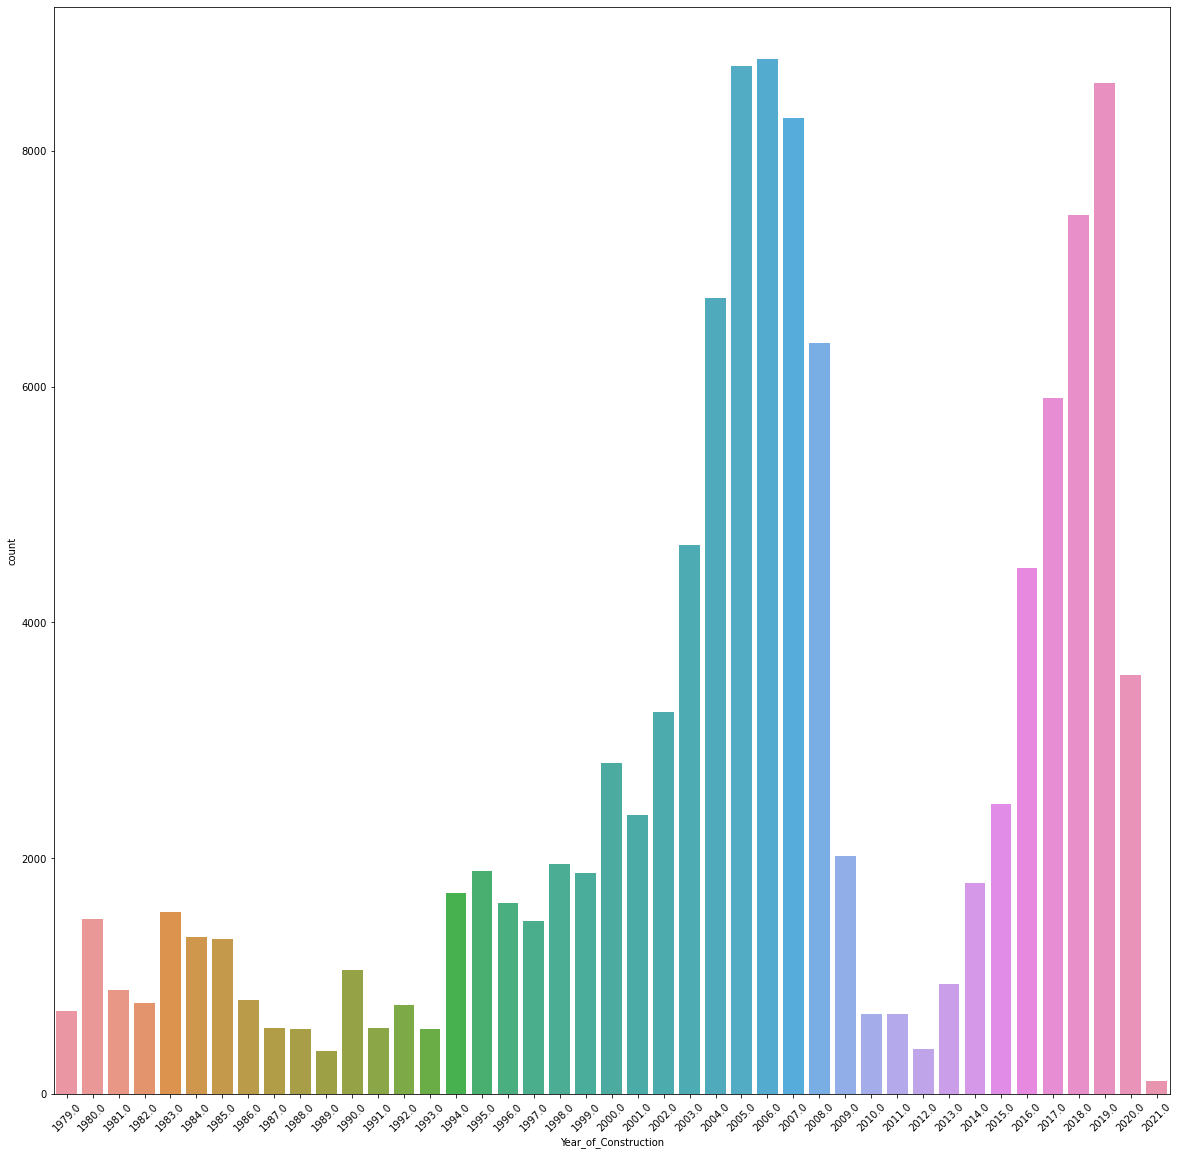

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.countplot(
    x=suitable_for_hps.query("`Year_of_Construction` > 1978").Year_of_Construction,
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

# Plot % HLP < 2 in Dublin

## Get Dublin Postcode Boundaries

In [ ]:
!wget --no-clobber -O {save_directory}/dublin_postcode_boundaries.zip https://zenodo.org/record/4327005/files/dublin_postcode_boundaries.zip
!unzip -d {save_directory} {save_directory}/dublin_postcode_boundaries.zip

In [29]:
dublin_postcode_boundaries = gpd.read_file(f"../data/dublin_postcode_boundaries")

## Plot %HH with HLP < 2 by Postcode

In [30]:
total_hh_by_county = (
    ber[ber["CountyName"].str.contains("Dublin")]
    .CountyName
    .value_counts()
    .rename("total")
)

In [31]:
percentage_suitable_for_hps_by_county = (
    suitable_for_hps[suitable_for_hps["CountyName"].str.contains("Dublin")]
    .CountyName
    .value_counts()
    .divide(total_hh_by_county)
    .multiply(100)
    .round(2)
    .rename("total")
)

In [33]:
graph = dublin_postcode_boundaries.merge(
    percentage_suitable_for_hps_by_county,
    left_on="postcodes",
    right_index=True,
)

Grab the centre point of each polygon so can overlay the postcode names on top of the polygons

... adapted from https://stackoverflow.com/questions/38899190/geopandas-label-polygons

In [34]:
graph['coords'] = graph['geometry'].apply(lambda x: x.representative_point().coords[:])
graph['coords'] = [coords[0] for coords in graph['coords']]

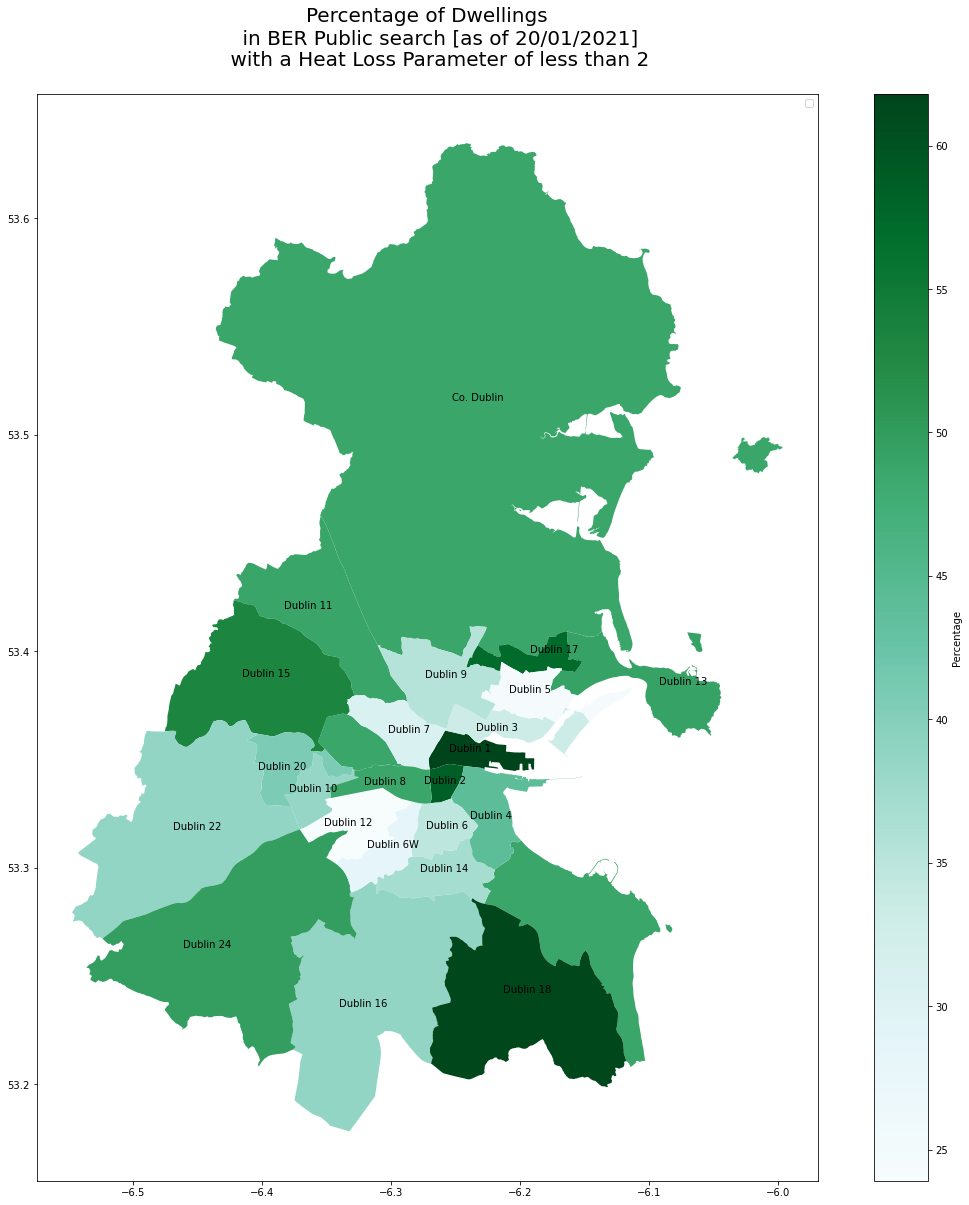

In [35]:
fig, ax = plt.subplots(figsize=(20, 20))
graph.plot(
    column="total",
    legend=True,
    ax=ax,
    legend_kwds={'label': "Percentage"},
    cmap="BuGn",
)
plt.title(
    """Percentage of Dwellings
    in BER Public search [as of 20/01/2021]
    with a Heat Loss Parameter of less than 2
    """, 
    fontsize=20
)
ax.legend(["Percentage"])
for idx, row in graph.iterrows():
    plt.annotate(
        s=row['postcodes'],
        xy=row['coords'],
        horizontalalignment='center',
        color="k",
    )

In [39]:
graph.drop(columns="coords").to_file("../data/dublin_postcode_hli.geojson", driver="GeoJSON")

# Get % HLP < 2 in Ireland

In [ ]:
percentage_of_homes_suitable = len(suitable_for_hps) / len(ber) * 100

In [ ]:
display(f"{round(percentage_of_homes_suitable)}% of HH in BER Public search database are suitable for HPs")